# Brownian motion simulation
We want here to simulate a regular Brownian motion.
Then, we will try to simulate a fractional Brownian motion.
We also want to study the time required to make all these simulations.
## Importing packages

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
%matplotlib inline

## Some global simulation parameters

In [88]:
N = 100  # Nombre de points de discrétisation

time = np.linspace(10**-5, 10, N)  # Temps de discrétisation

## Simulating a regular Brownian motion

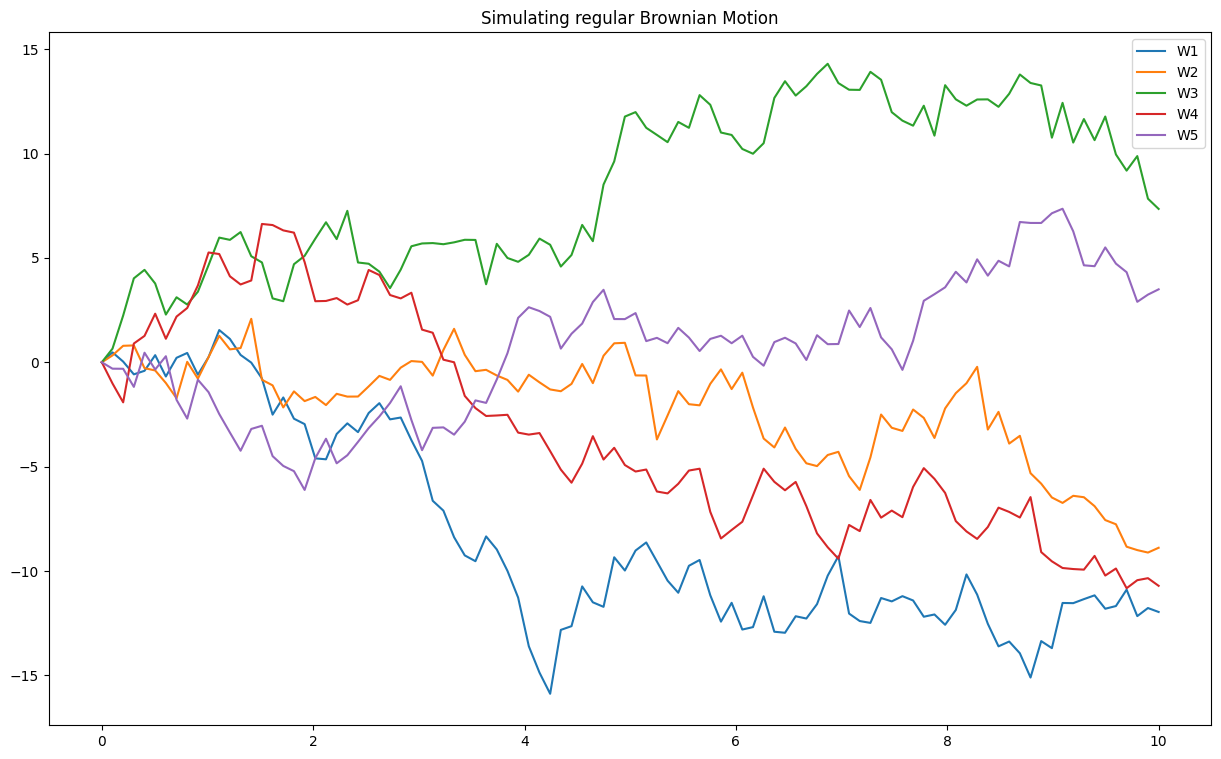

In [89]:
plt.figure(figsize=(15, 9))
plt.title('Simulating regular Brownian Motion')

for n in range(5):
    W = [0]
    for i in range(1,N):
        W.append(W[i-1] + np.random.normal(0, 1))
    plt.plot(time, W, label=f'W{n+1}')

plt.legend()
plt.show()

## Simulating a fractional Brownian motion
Now, we are going to simulate a fractional Brownian motion.
For that, we know:
$$\operatorname{Cov}(X_t, X_s) = \frac12 \left(t^{2\alpha} + s^{2\alpha} - \left|t-s\right|^{2\alpha}\right)$$
where $\alpha$ is the Hurst parameter.
- If $\alpha=\frac 12$, then we have a regular Brownian motion.
- If $\alpha<\frac12$, then all increments are negatively correlated.
- If $\alpha>\frac12$, then all increments are positively correlated.

Then, we will use the Cholesky decomposition to simulate a fractional Brownian motion.

How ever, when we have exactly $t=s=0$, then the covariance is not defined, as have $\sigma^2_{W_0}=0$.
So we will start from $t=s=10^{-5}$.

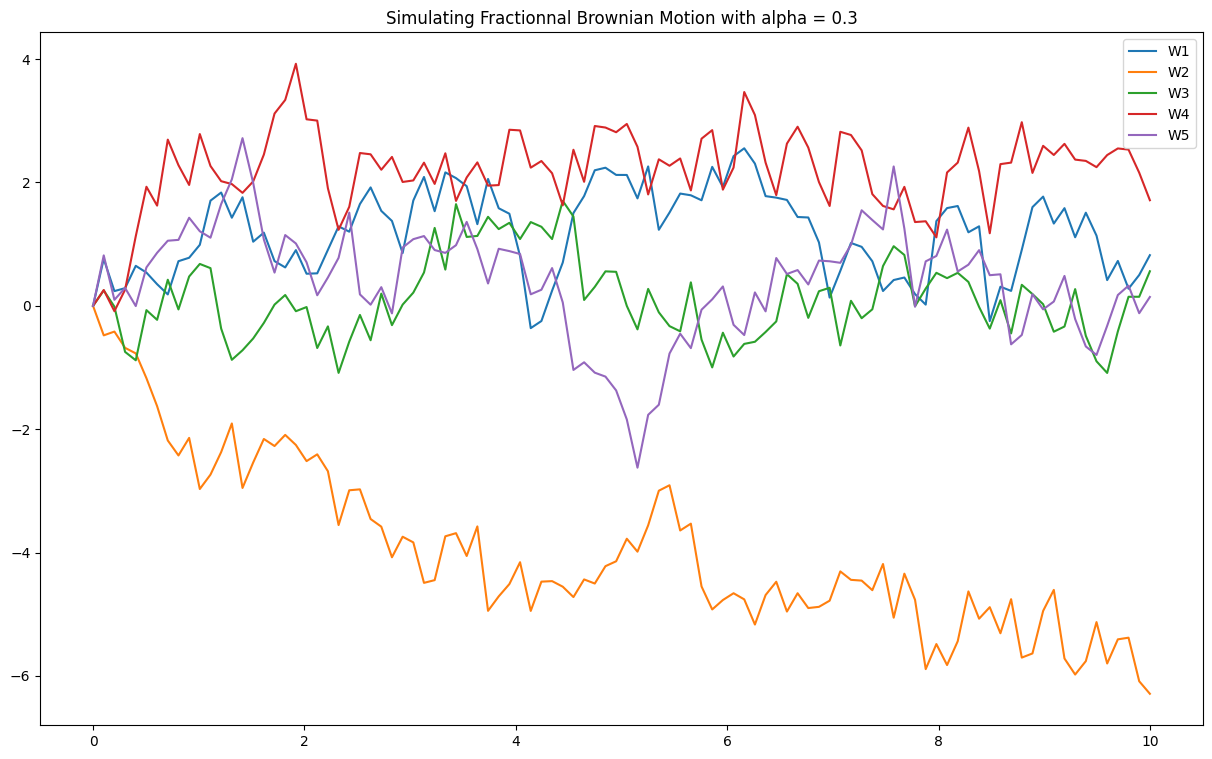

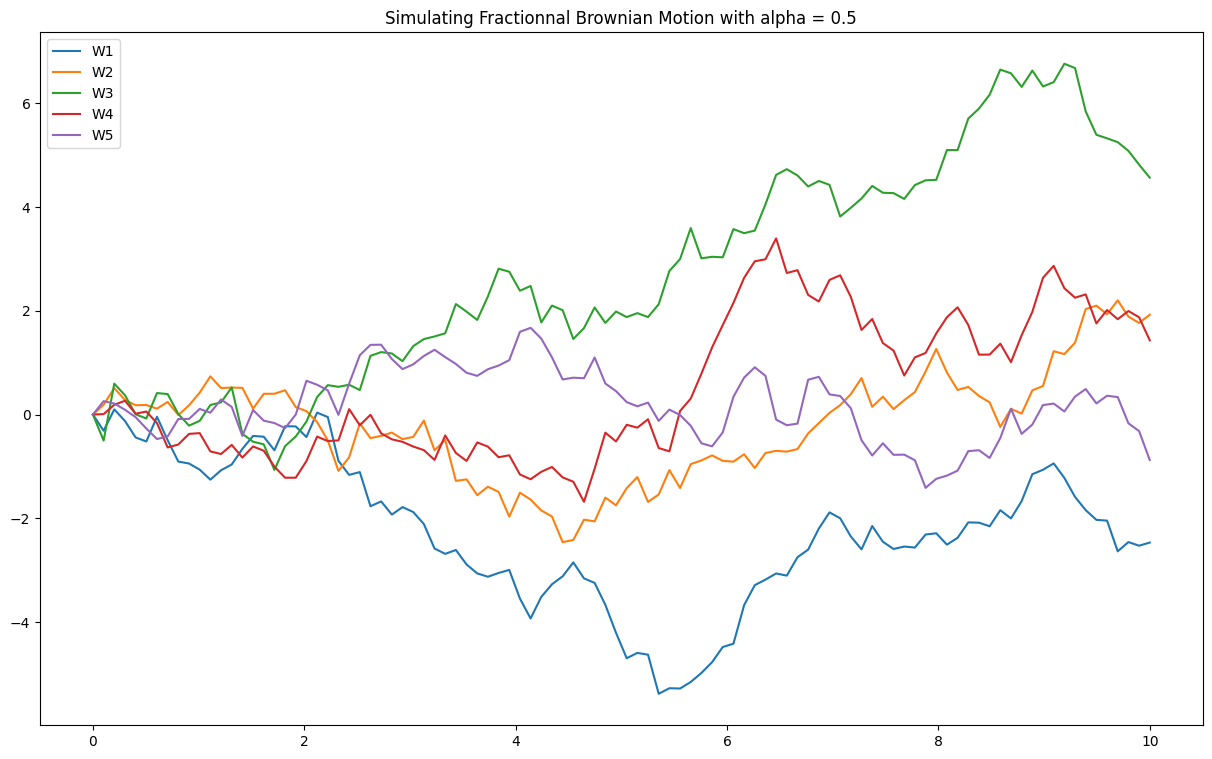

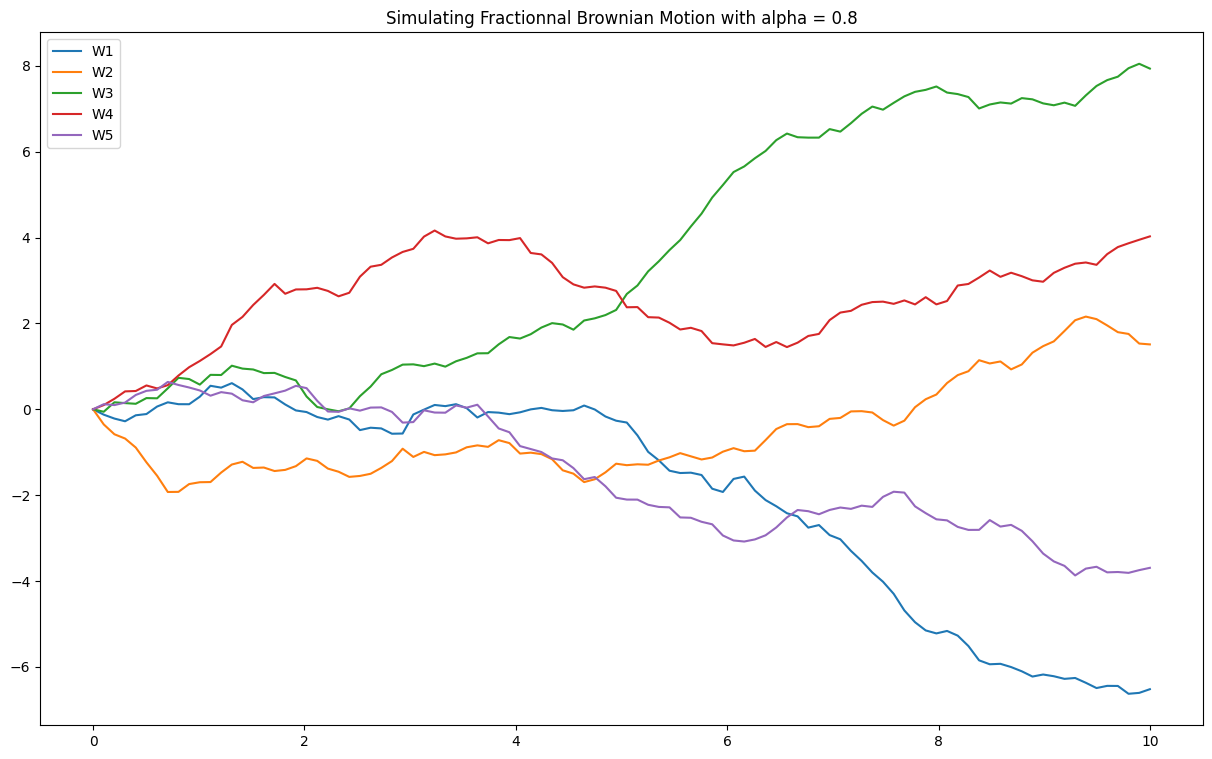

In [90]:
alphas = [0.3, 0.5, 0.8]  # Quelques valeurs de alpha

for alpha in alphas:
    plt.figure(figsize=(15, 9))
    plt.title(f'Simulating Fractionnal Brownian Motion with alpha = {alpha}')
    mat_cov = np.zeros((N, N))

    for t in range(N):
        for s in range(N):
            if (s > t):
                break
            mat_cov[t, s] = 0.5 * (time[t] ** (2 * alpha) + time[s] **
                                (2 * alpha) - np.abs(time[t] - time[s]) ** (2 * alpha))
            mat_cov[s,t] = mat_cov[t,s]

    C = np.linalg.cholesky(mat_cov)

    for i in range(5):
        Y = np.dot(C, np.random.normal(0, 1, N))
        Y[0] = 0
        plt.plot(time, Y, label=f'W{i+1}')
    plt.legend()
    plt.show()

## Riemann-Liouville Brownian motion

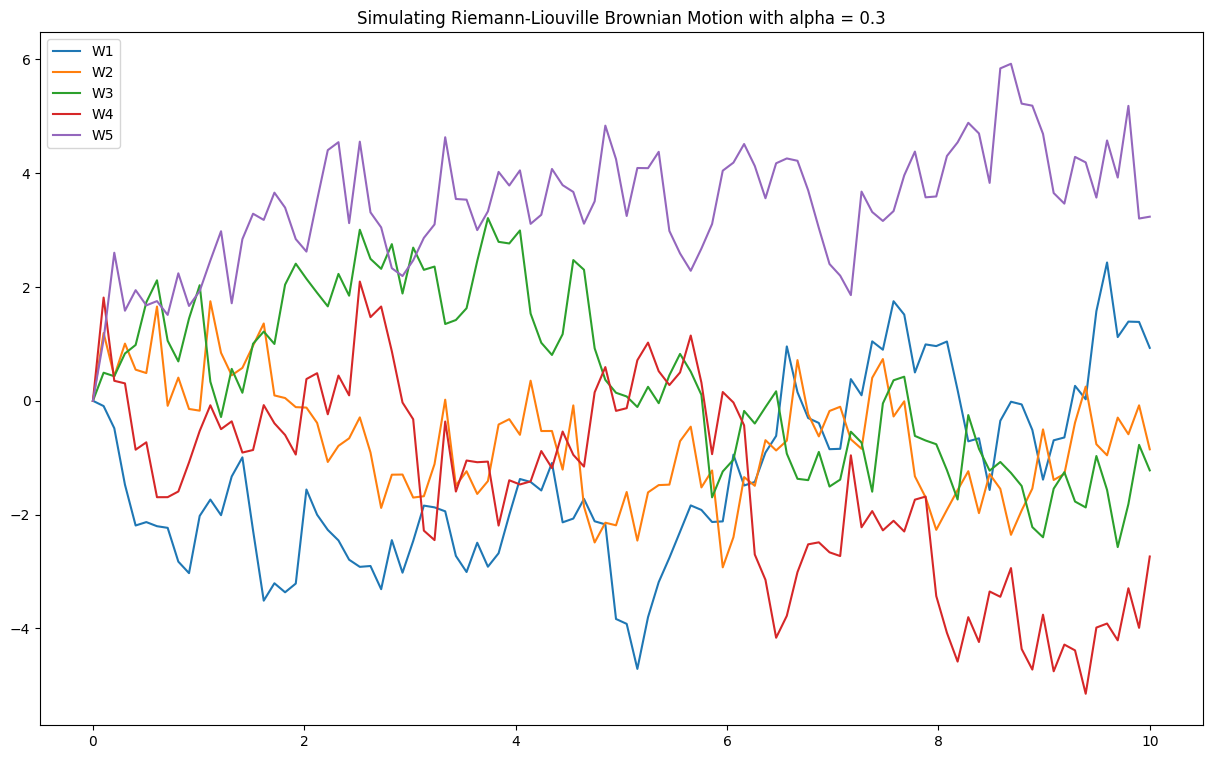

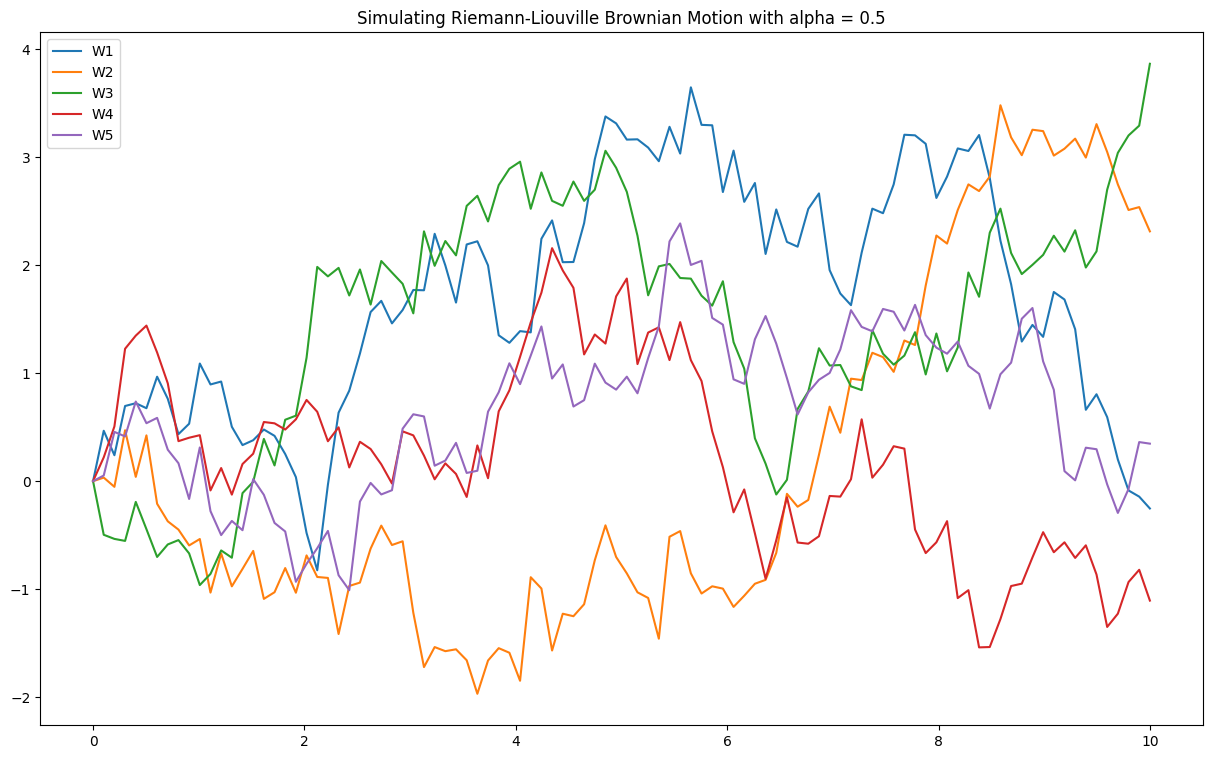

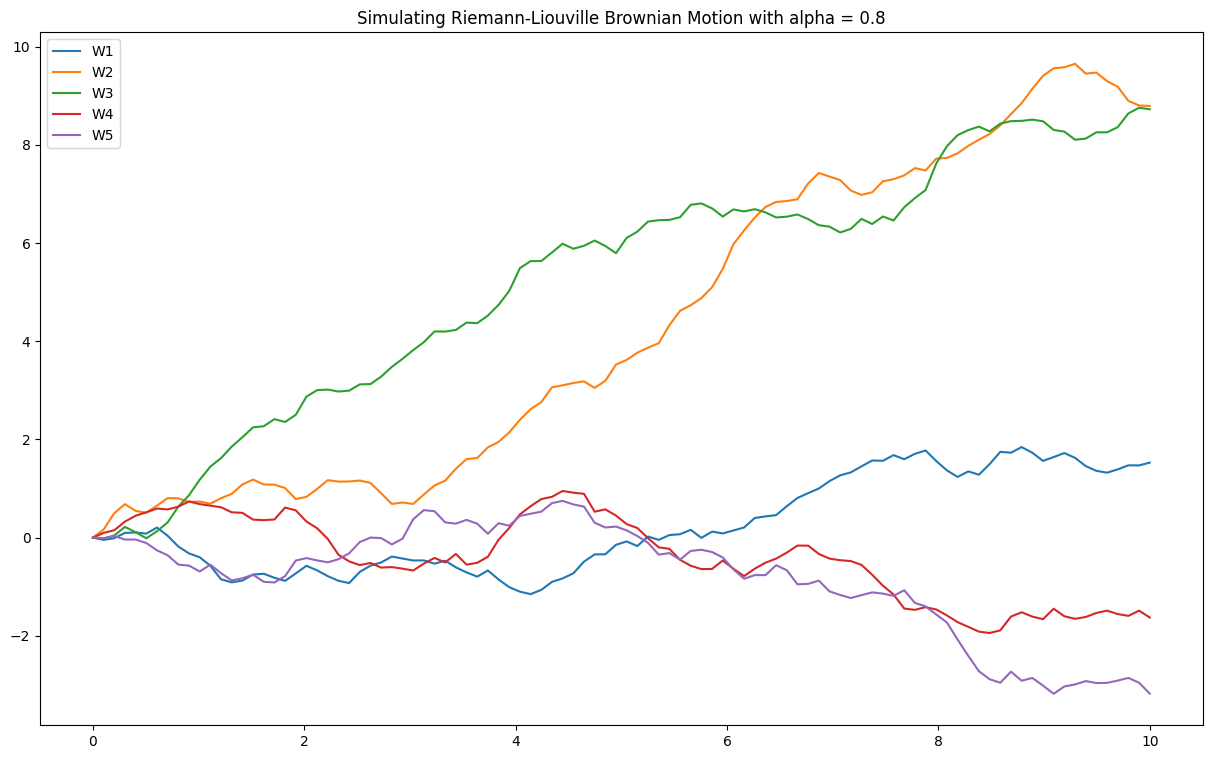

In [91]:
for alpha in alphas:
    plt.figure(figsize=(15, 9))
    plt.title(f'Simulating Riemann-Liouville Brownian Motion with alpha = {alpha}')
    mat_cov = np.zeros((N, N))

    for t in range(N):
        for s in range(N):
            if (s > t):
                break
            mat_cov[t, s] = quad(lambda x: (time[t] - x) ** (alpha - 0.5) * (time[s] - x) ** (alpha - 0.5), 0, time[s])[0]
            mat_cov[s,t] = mat_cov[t,s]
    
    C = np.linalg.cholesky(mat_cov)

    for i in range(5):
        Y = np.dot(C, np.random.normal(0, 1, N))
        Y[0] = 0
        plt.plot(time, Y, label=f'W{i+1}')
    plt.legend()
    plt.show()